<a href="https://colab.research.google.com/github/Ananthzeke/Deep-Learning/blob/main/Notebooks-Tensorflow/Deep_Feed_forward_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip

--2022-06-12 09:31:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4738776 (4.5M) [application/x-httpd-php]
Saving to: ‘DryBeanDataset.zip’

DryBeanDataset.zip  100%[===================>]   4.52M  11.1MB/s    in 0.4s    

2022-06-12 09:31:52 (11.1 MB/s) - ‘DryBeanDataset.zip’ saved [4738776/4738776]



In [2]:
!unzip DryBeanDataset.zip

Archive:  DryBeanDataset.zip
   creating: DryBeanDataset/
  inflating: DryBeanDataset/Dry_Bean_Dataset.arff  
  inflating: DryBeanDataset/Dry_Bean_Dataset.txt  
  inflating: DryBeanDataset/Dry_Bean_Dataset.xlsx  


In [3]:
import pandas as pd

In [4]:
df=pd.read_excel('/content/DryBeanDataset/Dry_Bean_Dataset.xlsx')

In [5]:
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [6]:
df['Class'].unique()

array(['SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', 'DERMASON'],
      dtype=object)

In [7]:
df=df.sample(frac=1)

In [8]:
import numpy as np
import tensorflow as tf

In [9]:
train,test,val=np.split(df,[int(0.8*len(df)), int(0.9*len(df))])

In [10]:
labels,indices = np.unique(df["Class"],return_inverse=True) 

In [11]:
indices

array([3, 3, 0, ..., 6, 1, 6])

In [12]:
def df_to_dataset(dataframe, batch_size=32):
  df = dataframe.copy()
  labels,indices = np.unique(df["Class"],return_inverse=True) 
  df = {key: value.values[:,tf.newaxis] for key, value in dataframe.items()}
  df.pop('Class')
  ds = tf.data.Dataset.from_tensor_slices((dict(df), tf.one_hot(indices,7)))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [13]:
batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, batch_size=batch_size)
test_ds = df_to_dataset(test, batch_size=batch_size)

In [14]:
def get_normalization_layer(name, dataset):
  normalizer = tf.keras.layers.Normalization(axis=None)
  feature_ds = dataset.map(lambda x, y: x[name])
  normalizer.adapt(feature_ds)
  return normalizer


In [15]:
numerical_cols = df.drop('Class',axis=1).columns
numerical_cols

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4'],
      dtype='object')

In [16]:
all_inputs =[]
encoded_features=[]

In [17]:
for header in numerical_cols:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

In [18]:
x = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dense(16, activation="relu")(x)
x = tf.keras.layers.Dense(8, activation="relu")(x)
outputs = tf.keras.layers.Dense(7, activation="softmax")(x)
model = tf.keras.Model(all_inputs,outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

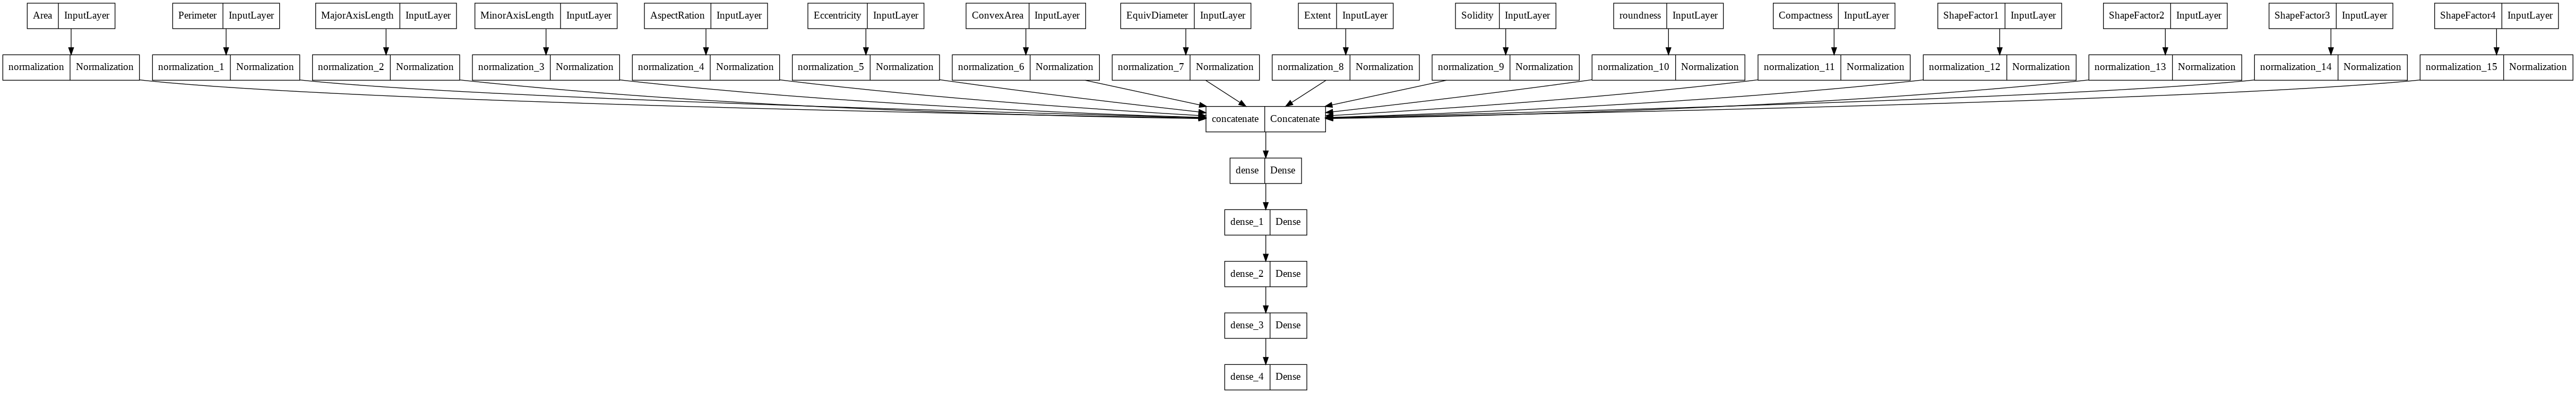

In [19]:
tf.keras.utils.plot_model(model)

In [20]:
history = model.fit(train_ds,validation_data=val_ds,epochs=100,callbacks=tf.keras.callbacks.EarlyStopping(patience=5))

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


171/171 [==============================] - 8s 14ms/step - loss: 1.1956 - accuracy: 0.5427 - val_loss: 0.5451 - val_accuracy: 0.8722
Epoch 2/100
171/171 [==============================] - 2s 9ms/step - loss: 0.3023 - accuracy: 0.9112 - val_loss: 0.2524 - val_accuracy: 0.9097
Epoch 3/100
171/171 [==============================] - 1s 5ms/step - loss: 0.2186 - accuracy: 0.9210 - val_loss: 0.2352 - val_accuracy: 0.9134
Epoch 4/100
171/171 [==============================] - 1s 5ms/step - loss: 0.2060 - accuracy: 0.9237 - val_loss: 0.2256 - val_accuracy: 0.9163
Epoch 5/100
171/171 [==============================] - 1s 5ms/step - loss: 0.1995 - accuracy: 0.9266 - val_loss: 0.2188 - val_accuracy: 0.9207
Epoch 6/100
171/171 [==============================] - 1s 5ms/step - loss: 0.1953 - accuracy: 0.9284 - val_loss: 0.2155 - val_accuracy: 0.9200
Epoch 7/100
171/171 [==============================] - 1s 5ms/step - loss: 0.1923 - accuracy: 0.9296 - val_loss: 0.2120 - val_accuracy: 0.9200
Epoch 8/10

In [21]:
history = history.history

In [22]:
import matplotlib.pyplot as plt


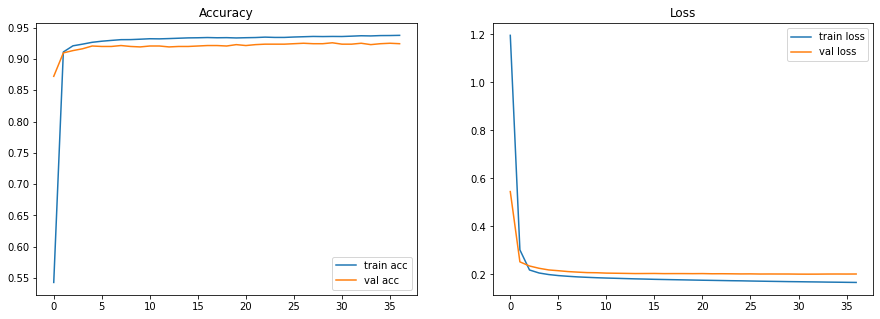

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Accuracy")
plt.plot(history["accuracy"],label="train acc")
plt.plot(history["val_accuracy"],label="val acc")
plt.legend()

plt.subplot(122)
plt.title("Loss")
plt.plot(history["loss"],label="train loss")
plt.plot(history["val_loss"],label="val loss")
plt.legend()

plt.show()


In [24]:
loss ,accuracy = model.evaluate(test_ds)

22/22 [==============================] - 0s 4ms/step - loss: 0.2332 - accuracy: 0.9295


In [25]:
print("test loss :",loss)
print("test accuracy :",accuracy)

test loss : 0.23324495553970337
test accuracy : 0.9294636249542236
